# Jupyter_Notebook_Final_Draft

### Outline

- Working with dataset from TheNumbers
- Rotten Tomatoes Data Set
- Understanding The IMBD Data Set
- Exploring Microsofts IPs within the Gaming Industry

Imported All Libraries Used

In [1]:
import pandas as pd
import numpy as np
import zipfile 
import sqlite3

import requests
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline


## Working with dataset from 'The-Numbers.com'

In [2]:
#Load 'The Numbers' dataset
tn_df = pd.read_csv('./data/tn.movie_budgets.csv.gz')
tn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


The dataset has no null values and includes columns for production_budget, domestic_gross and worldwide_gross however, they are all strings. First lets confirm that all numbers are dealing in the same currency ('$')

In [3]:
print("Is the production budget in dollars for all records?: ",tn_df['worldwide_gross'].str.startswith('$').sum() == len(tn_df))
print("Is the domestic gross in dollars for all records?: ",tn_df['domestic_gross'].str.startswith('$').sum() == len(tn_df))
print("Is the worldwide gross in dollars for all records?: ",tn_df['worldwide_gross'].str.startswith('$').sum() == len(tn_df))

Is the production budget in dollars for all records?:  True
Is the domestic gross in dollars for all records?:  True
Is the worldwide gross in dollars for all records?:  True


It looks all the business related data is in dollars. We can safely convert all the numbers without having to do any currency conversions. To ensure we don't lose track, a currency column is created to include the "$" symbol and all numbers are then proceeded to be converted to numbers

In [4]:
#Converting production buget, domestic gross, worldwide gross to numbers, Add currency unit column as a reminder 
#numbers are in $
tn_df['currency'] = '$'
tn_df['production_budget'] = tn_df['production_budget'].str.replace(',','').str.replace('$','').astype(int)
tn_df['domestic_gross'] = tn_df['domestic_gross'].str.replace(',','').str.replace('$','').astype(int)
tn_df['worldwide_gross'] = tn_df['worldwide_gross'].str.replace(',','').str.replace('$','').astype('int64')

Using these we can calculate the net revenue a movie generated

Note: Worldwide gross constitutes domestic gross. Therefore Foreign Gross = World Wide Gross - Domestic Gross

In [5]:
#Adding net revenue column and a foreign gross column
tn_df['foreign_gross'] = tn_df['worldwide_gross'] - tn_df['domestic_gross']
tn_df['net_revenue'] = tn_df['worldwide_gross'] - tn_df['production_budget']

Converting release_date to date time and appending month and year columns

In [6]:
tn_df['release_date'] = pd.to_datetime(tn_df['release_date'])
tn_df['release_year'] = tn_df['release_date'].dt.year
tn_df['release_month'] = tn_df['release_date'].dt.month

## Why should Microsoft get into movies?

Aside from owning IPs that lend itself to making good visual content, we can ascertain whether there is a business reason to get into movie making.Lets look at gross and net revenue performance of the box office by the year for the last 20 years

In [7]:
# Trend data for gross and net revenue across a time spread
trend_viz_df = tn_df[(tn_df['worldwide_gross']!=0)&(tn_df['net_revenue']!=0)] #remove entries with 0 for revenue and gross
trend_viz_df = trend_viz_df[(trend_viz_df['release_year']>=2000) & (trend_viz_df['release_year']<=2018)] #limit table release years
trend_viz_df = trend_viz_df.groupby('release_year').mean().reset_index() #get mean gross and revenue for each year

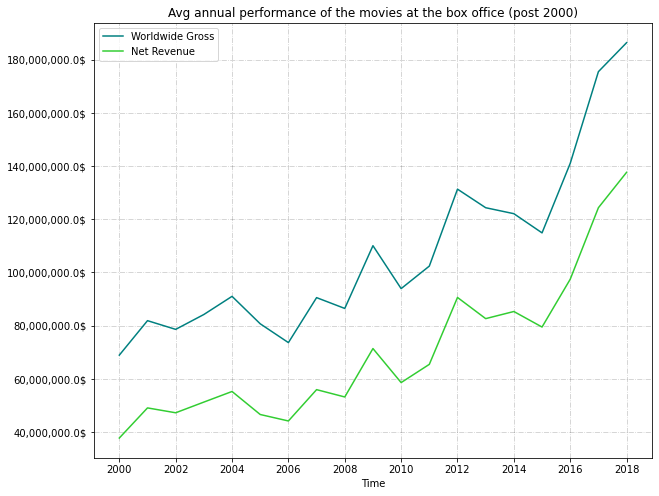

In [8]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(list(trend_viz_df['release_year']), list(trend_viz_df['worldwide_gross']),'teal')
ax.plot(list(trend_viz_df['release_year']), list(trend_viz_df['net_revenue']),'limegreen')

ax.set_xlabel('Time')
ax.set_xticks(np.arange(2000,2020,2))
ax.get_yaxis().set_major_formatter(ticker.StrMethodFormatter('{x:,}$'))

ax.set_title('Avg annual performance of the movies at the box office (post 2000)')
ax.legend(['Worldwide Gross','Net Revenue'])
ax.grid(c='k',ls= '-.',alpha = 0.2);

# fig.savefig('./images/AnnualMeanPerformance.jpg',
#             transparent = False);

## Best Release time of the year

Limiting data to post Insert cut off year or essentially last 10 years worth of data. This will help us to emphasize more recent trends. For te purpose of visualization we will be using world wide earnings. Dropping records with no world wide earnings data

In [9]:
# Paring down the dataset by a cutoff year to ascertain more recent trends focusing on worldwide revenue
reduced_df = tn_df[tn_df['release_year']>=2012]
reduced_df_worldwide = reduced_df.drop(reduced_df[reduced_df['worldwide_gross']==0].index)

Using the revenue data we can try to ascertain the best release windows for movies. We can see major revenue being generated during the summer season (May, June, July) and again during holiday season

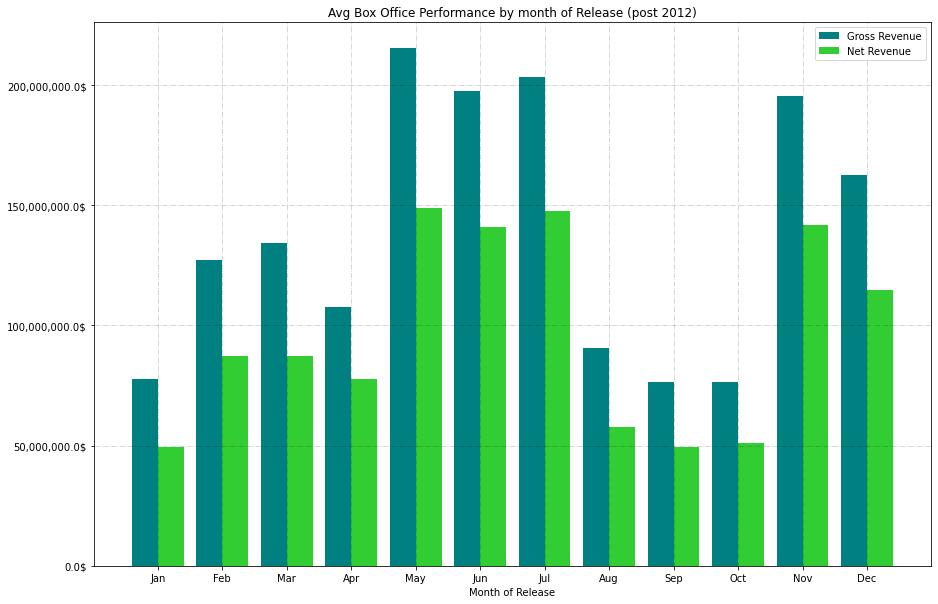

In [10]:
#Plot avg performance at the box office

fig,ax = plt.subplots(figsize = (15,10))

df = reduced_df_worldwide.groupby('release_month').mean()

#Graphs for mean gross/net revenue by the month
x = df['worldwide_gross'].index
w = 0.4

ax.set_title(f'Avg Box Office Performance by month of Release (post 2012)')

plt.xticks(ticks=[1,2,3,4,5,6,7,8,9,10,11,12],
           labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])

ax.bar(x-w/2, df['worldwide_gross'], w,color = 'teal')
ax.bar(x+w/2, df['net_revenue'], w,color = 'limegreen')

ax.set_xticks(np.arange(1,13,step=1))
ax.set_xlabel('Month of Release')

ax.get_yaxis().set_major_formatter(ticker.StrMethodFormatter('{x:,}$'))
ax.legend(['Gross Revenue', 'Net Revenue'])
ax.grid(c='k',ls= '-.',alpha = 0.2);

# fig.savefig('./images/MonthlyReleaseMeanPerformance.jpg',
#             transparent = False);

.

# Rotten_Tomatoes_dataset

In [11]:
#Load review info from Rotten Tomatoes
rt_review_df = pd.read_csv('./data/rt.reviews.tsv.gz',delimiter='\t',encoding = 'unicode_escape')
rt_review_df['publisher'].fillna('N/A',inplace = True)

# Don't need written review. Date in this instance is review date and irrelevant
rt_review_df.drop(columns = ['review','date'], inplace = True)
rt_review_df['fresh_flag'] = (rt_review_df['fresh']=='fresh') #creates a boolean column for 'fresh'/'rotten'

rt_review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54432 non-null  int64 
 1   rating      40915 non-null  object
 2   fresh       54432 non-null  object
 3   critic      51710 non-null  object
 4   top_critic  54432 non-null  int64 
 5   publisher   54432 non-null  object
 6   fresh_flag  54432 non-null  bool  
dtypes: bool(1), int64(2), object(4)
memory usage: 2.5+ MB


ID in this table is a unique movie identifier across rotten tomato datasets.
A movie can have multiple reviews. Therefore, we can get the 'Fresh' rating across all review and across all 'top critics' for every ID

In [12]:
#Paring the data down to only the 'top critics'
#This returns a series of tomato ratings as rated by top critics. Index by id
top_critic_reviews_sr = rt_review_df[rt_review_df['top_critic']==1].groupby('id').mean()['fresh_flag']

In [13]:
#This returns a series of tomato ratings as rated by all critics. Index by id
all_reviews_sr = rt_review_df.groupby('id').mean()['fresh_flag']

In [14]:
#Load movie info from Rotten Tomatoes
rt_movie_df = pd.read_csv('./data/rt.movie_info.tsv.gz',delimiter = '\t')

# NOTE: No movie title provided in dataset. And unique identifier 'id' cannot be matched
# to another db.

#Create list of genres for each record
rt_movie_df['genre list'] = rt_movie_df['genre'].str.split('|')

# Convert runtime to numerical data
rt_movie_df['runtime_in_min'] = rt_movie_df['runtime'].map(lambda x: int(x[:-8]) if x is not np.nan else np.nan)

# Converting theater date to datetime object and creating year column
rt_movie_df['theater_date'] = pd.to_datetime(rt_movie_df['theater_date'])
rt_movie_df['year'] = rt_movie_df['theater_date'].dt.year

#'currency' and 'box_office' columns are about 4/5 empty. Dropping these columns. 
# Other datasets are morecomplete and this data can be gathered from there instead 
# Dropping synopsis and studio as well
rt_movie_df.drop(columns = ['synopsis','currency','box_office','studio','runtime'],inplace=True)

In [15]:
rt_movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              1560 non-null   int64         
 1   rating          1557 non-null   object        
 2   genre           1552 non-null   object        
 3   director        1361 non-null   object        
 4   writer          1111 non-null   object        
 5   theater_date    1201 non-null   datetime64[ns]
 6   dvd_date        1201 non-null   object        
 7   genre list      1552 non-null   object        
 8   runtime_in_min  1530 non-null   float64       
 9   year            1201 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 122.0+ KB


Having calculated the 'Fresh' meter for each movie already we can create a column for each and add it to this master table

In [16]:
rt_movie_df['overall_tomato_rating'] = rt_movie_df['id'].map(lambda x: all_reviews_sr[x] if x in all_reviews_sr else np.nan)
rt_movie_df['top_critic_tomato_rating'] = rt_movie_df['id'].map(lambda x: top_critic_reviews_sr[x] if x in top_critic_reviews_sr else np.nan)

## Genre Performance

Drop every record with a na in genre. Create a boolean matrix for all different genres. Drop unneccessary columns

In [17]:
unique_genre_list = []
for genres in rt_movie_df['genre list'].dropna().tolist():
    for genre in genres:
        unique_genre_list.append(genre)
unique_genre_list =list(set(unique_genre_list))

In [18]:
rt_movie_genre_df = rt_movie_df[rt_movie_df['genre list'].notna()]


for genre in unique_genre_list:
    rt_movie_genre_df[genre] = rt_movie_genre_df['genre list'].map(lambda x: True if genre in x else False)

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [19]:
# Get top 15 most released genres
rt_movie_genre_temp = rt_movie_genre_df[rt_movie_genre_df['year']>2000].drop(
    columns = ['rating','genre list','year','overall_tomato_rating','top_critic_tomato_rating',
               'id','genre','dvd_date','runtime_in_min'])
top_15_genres = list(rt_movie_genre_temp.sum().sort_values(ascending=False)[:15].index)

In [20]:
rt_movie_genre_temp.sum().sort_values(ascending=False)[:15]

Drama                          278
Comedy                         176
Action and Adventure           102
Mystery and Suspense            98
Art House and International     65
Romance                         57
Science Fiction and Fantasy     51
Horror                          40
Kids and Family                 35
Documentary                     28
Animation                       24
Special Interest                20
Musical and Performing Arts     19
Television                       8
Faith and Spirituality           7
dtype: int64

In [21]:
viz_data =[]
for genre in top_15_genres:
    grouped_df = rt_movie_genre_df[rt_movie_genre_df['year']>2000].groupby(genre).mean()
    viz_data.append([genre,grouped_df['overall_tomato_rating'][1],grouped_df['top_critic_tomato_rating'][1]]) 
viz_data.sort(key = lambda x: x[1],reverse = True)

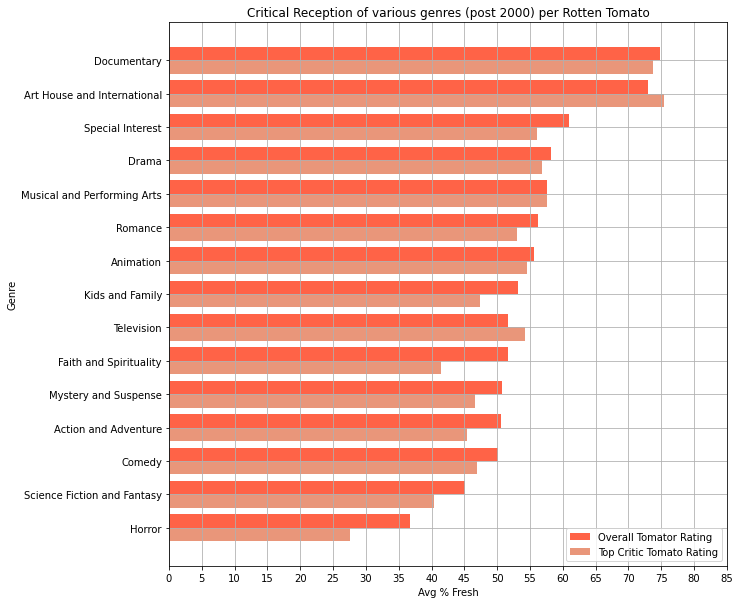

In [22]:
# Visualization
viz_labels = [v[0] for v in viz_data]
viz_all_ratings = [v[1]*100 for v in viz_data]
viz_top_ratings = [v[2]*100 for v in viz_data]

y = np.arange(len(viz_labels))
h = 0.6

fig, ax = plt.subplots(figsize=(10,10))


ax.grid()

ax.set_title(f'Critical Reception of various genres (post 2000) per Rotten Tomato')
ax.set_ylabel('Genre')
ax.set_xlabel('Avg % Fresh')

ax.barh(y-h/3, viz_all_ratings, h/1.5,color='tomato')
ax.barh(y+h/3, viz_top_ratings, h/1.5,color='darksalmon')

ax.set_xticks(np.arange(0, 90, step=5))

ax.set_yticks(y)  
ax.set_yticklabels(labels=viz_labels)
ax.legend(['Overall Tomator Rating', 'Top Critic Tomato Rating'])
ax.invert_yaxis()

fig.savefig('./images/PopularGenres_Critics.jpg',
            transparent = False,bbox_inches="tight");

.

.

.

# Understanding the IMDb Dataset

First, we'll need to set up our notebook to be able to process this data.

In [23]:
# Import necessary libraries and packages
import pandas as pd
import numpy as np
import sqlite3
import zipfile
import matplotlib.pyplot as plt

%matplotlib inline

In [24]:
# Extract IMDb SQL .db file
with zipfile.ZipFile('./data/im.db.zip') as zipObj:
    # Extract all contents of .zip file into current directory
    zipObj.extractall(path='../../data/')
    
# Create connection to IMDb DB
con = sqlite3.connect('../../data/im.db')

Let's take a look at what this dataset actually *contains*, i.e. the names of the tables

In [25]:
pd.read_sql("""

SELECT *
FROM sqlite_master

""",con)

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


For starters, let's take a look at the `movie_basics` and `movie_ratings` tables.

In [26]:
basics_query = """SELECT * FROM movie_basics"""

pd.read_sql(basics_query,con).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


146,144 entries - that's a **lot** of movies!

We have a few columns with null values: ```original_title```, ```runtime_minutes```, and ```genres```. We'll have to figure out how to deal with those in due time, but first, let's get a closer look at what's actually contained in the table.

In [27]:
pd.read_sql(basics_query,con).head(10)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
5,tt0111414,A Thin Life,A Thin Life,2018,75.0,Comedy
6,tt0112502,Bigfoot,Bigfoot,2017,NaN,"Horror,Thriller"
7,tt0137204,Joe Finds Grace,Joe Finds Grace,2017,83.0,"Adventure,Animation,Comedy"
8,tt0139613,O Silêncio,O Silêncio,2012,NaN,"Documentary,History"
9,tt0144449,Nema aviona za Zagreb,Nema aviona za Zagreb,2012,82.0,Biography


Since most of the movies in the dataset have the same `primary_title` and `original_title`, and because `primary_title` is often an English-translated title, we can probably drop `original_title` when we join these tables.

We also have a primary key: `movie_id`.

Okay, what about the table `movie_ratings`?

In [28]:
ratings_query = """SELECT * FROM movie_ratings"""

pd.read_sql(ratings_query,con).head(10)

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21
5,tt1069246,6.2,326
6,tt1094666,7.0,1613
7,tt1130982,6.4,571
8,tt1156528,7.2,265
9,tt1161457,4.2,148


That table is easy enough to read, but it only gives us **alphanumeric values** to identify what movie is associated with a given row's `averagerating` and `numvotes`. We will address that when we join the tables.

Let's take a more bird's-eye view of the `movie_ratings` table using `.info()`.

In [29]:
pd.read_sql(ratings_query,con).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


No null values in any of the three columns! But `movie_ratings`, with 73,856 rows, has only *half* as many entries as `movie_basics` - that means there are a lot of entries in `movie_basics` without an associated rating.

The two tables have `movie_id` in common, so we'll join them on that column.

Which column should we investigate first in order to get a sense of what movies (and what kinds of movies) are popular: `averagerating` or `numvotes`?

The values in the column `averagerating` provide us an idea of what *scores* IMDb users have assigned a movie (i.e. users' *evaluations* of a movie's quality), but `numvotes` tells us *how many* IMDb users have rated the movie, which likely gives us a better idea of a movie's **reach**. Let's order our data by `numvotes` to start.

In [30]:
# Creating new query: Joining movie_basics and
# movie_ratings, ordering by total # of ratings

votes_query = """
    SELECT
        -- Importing columns from movie_basics
        mb.primary_title AS "Title",
        mb.start_year AS "Release Year",
        -- Importing columns from movie_ratings
        mr.averagerating AS "Avg. Rating",
        mr.numvotes AS "# of Ratings"
    FROM
        movie_basics AS mb
        JOIN movie_ratings AS mr
            ON mb.movie_id = mr.movie_id
    WHERE
        -- Looking at movies only from 2010-2019 (most recent
        -- year in dataset) for last ten years' of data
        mb.start_year >= 2010
    ORDER BY
        mr.numvotes DESC
"""

# Creating new dataframe based on votes_query
sample_df = pd.read_sql(votes_query,con)

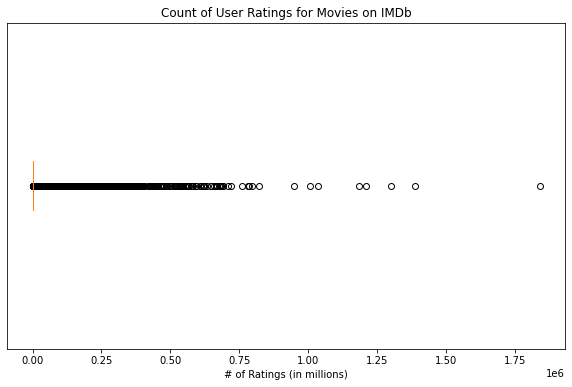

In [31]:
# Assigning the values from '# of Ratings' column to
# new variable ratings_counts
ratings_counts = sample_df['# of Ratings']

# Plotting ratings_counts as a boxplot
fig, ax = plt.subplots(figsize=(10,6))

plt.tick_params(
    axis='y',
    which='both',
    left=False,
    labelleft=False)

ax.boxplot(ratings_counts, vert=False)
ax.set_title("Count of User Ratings for Movies on IMDb")
ax.set_xlabel("# of Ratings (in millions)");

That is a very skewed boxplot - it's hard to even make any sense of it. Let's look at the descriptive statistics for the `# of Ratings` column.

In [32]:
ratings_counts.describe().apply(lambda x: format(x, 'f'))

count      73856.000000
mean        3523.662167
std        30294.022971
min            5.000000
25%           14.000000
50%           49.000000
75%          282.000000
max      1841066.000000
Name: # of Ratings, dtype: object

(The function to convert the output of `ratings_counts.describe()` from scientific notation to the above notation was provided by [Ash Upadhyay](https://stackoverflow.com/posts/47207283/revisions).)

Wow... not only is our ```mean``` well above the ```50%``` value (the median), but it's **more than ten times larger** than the ```75%``` value! The most popular movie on the site is represented by `max` and has 1,841,066 ratings. 

From a business perspective, it probably doesn't make a lot of sense to home in on movies with low numbers of user ratings. In the SQL query below, we order by `numvotes`/`# of Ratings` once again, but we limit our output to 500. This yields a dataframe with information about the 500 movies with the greatest number of user ratings - not only is it more manageable than working with thousands of records, we're also only working movies that are verifiably **popular** with IMDb users.

In [33]:
imdb_df_sample = pd.read_sql("""
    SELECT
        -- Importing columns from movie_basics
        mb.primary_title AS "Title",
        mb.start_year AS "Release Year",
        mb.genres AS "genres",
        mb.runtime_minutes AS "Runtime",
        -- Importing columns from movie_ratings
        mr.averagerating AS "Avg. Rating",
        mr.numvotes AS "# of Ratings"
    FROM
        movie_basics AS mb
        JOIN movie_ratings AS mr
            ON mb.movie_id = mr.movie_id
    WHERE
        -- Looking at movies only with more than 100,000
        -- user ratings
        mr.numvotes >= 100000 AND
        -- Looking at movies only from 2010-2019 (most recent
        -- year in dataset)
        mb.start_year >= 2010
    ORDER BY
        mr.numvotes DESC
    LIMIT 500
""",con)

print(imdb_df_sample.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Title         500 non-null    object 
 1   Release Year  500 non-null    int64  
 2   genres        500 non-null    object 
 3   Runtime       500 non-null    float64
 4   Avg. Rating   500 non-null    float64
 5   # of Ratings  500 non-null    int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 23.6+ KB
None


Okay, so we've got a sample of 500 movies, each of which has been rated *at least* 100,000 times by IMDb users (though we cannot guarantee these are all unique users.) This sample represents the 500 movies on the site with the greatest number of user ratings.

In [34]:
# Database column 'genres' gives us multiple genres separated
# by commas -- using split() to create a LIST of genres
imdb_df_sample['genres'] = imdb_df_sample['genres'].str.split(',')

# Let's look at the 10 movies with the highest # of user ratings
imdb_df_sample.head(10)

,Title,Release Year,genres,Runtime,Avg. Rating,# of Ratings
0,Inception,2010,"[Action, Adventure, Sci-Fi]",148.0,8.8,1841066
1,The Dark Knight Rises,2012,"[Action, Thriller]",164.0,8.4,1387769
2,Interstellar,2014,"[Adventure, Drama, Sci-Fi]",169.0,8.6,1299334
3,Django Unchained,2012,"[Drama, Western]",165.0,8.4,1211405
4,The Avengers,2012,"[Action, Adventure, Sci-Fi]",143.0,8.1,1183655
5,The Wolf of Wall Street,2013,"[Biography, Crime, Drama]",180.0,8.2,1035358
6,Shutter Island,2010,"[Mystery, Thriller]",138.0,8.1,1005960
7,Guardians of the Galaxy,2014,"[Action, Adventure, Comedy]",121.0,8.1,948394
8,Deadpool,2016,"[Action, Adventure, Comedy]",108.0,8.0,820847
9,The Hunger Games,2012,"[Action, Adventure, Sci-Fi]",142.0,7.2,795227


It looks like we have a pretty wide range of runtimes, and several of the movies with the highest average ratings on the site clock in at **over 2.5 hours!** Given the lack of correlation between a movie's runtime and its performance with critics we observed in the RottenTomatoes data, we can safely drop ```runtime_minutes``` / ```Runtime``` and focus on the other columns instead.

In [35]:
imdb_df_sample.drop(columns=['Runtime'], inplace=True)

Let's get a closer look at the `genres` column so that we can figure out what genres occur most frequently in this set of movies with 100,000+ user ratings.

In [36]:
imdb_df_sample['genres']

0      [Action, Adventure, Sci-Fi]
1               [Action, Thriller]
2       [Adventure, Drama, Sci-Fi]
3                 [Drama, Western]
4      [Action, Adventure, Sci-Fi]
                  ...             
495               [Drama, Romance]
496          [Drama, Mystery, War]
497              [Crime, Thriller]
498                [Comedy, Drama]
499     [Drama, Mystery, Thriller]
Name: genres, Length: 500, dtype: object

Looks like the ```genres``` column has a *list* of genres for each entry. We're going to need to split those lists up in order to get accurate value counts for each genre. (Credit for this function goes to [Max Hilsdorf](https://towardsdatascience.com/dealing-with-list-values-in-pandas-dataframes-a177e534f173).)

In [37]:
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

# Top ten most frequently occurring genres
top_genres = to_1D(imdb_df_sample['genres']).value_counts().head(10)

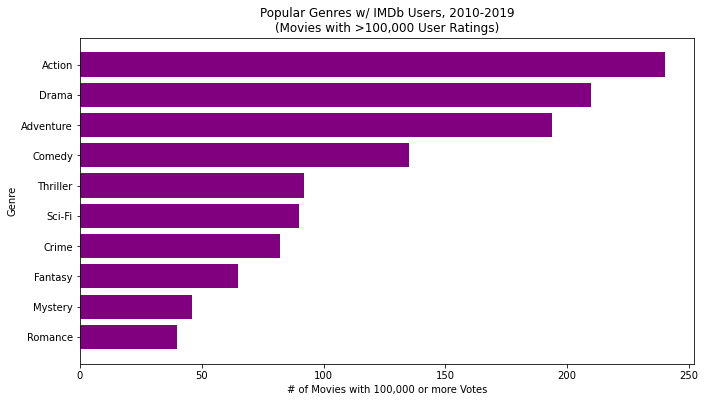

In [38]:
# Plotting top ten genres
genres_fig, ax = plt.subplots(figsize = (11, 6))

ax.invert_yaxis()
ax.barh(y=top_genres.index,
       width=top_genres,
       color='purple',)
ax.set_title("""Popular Genres w/ IMDb Users, 2010-2019
(Movies with >100,000 User Ratings)""")
ax.set_xlabel("# of Movies with 100,000 or more Votes")
ax.set_ylabel("Genre");

Interesting. It looks like `Action` is the most popular genre, with nearly **half** of the 500 most-frequently-rated movies containing `Action` in their list of genres!

`Drama` and `Adventure` sit in the second and third place slots, respectively, with `Comedy` in fourth place; this lends credence to the interpretation that `Drama` films reach a wider swath of moviegoers, though `Comedy` remains very popular. `Thriller` movies round out the top five.

If we subset our data so that we're only looking at the most recent five years' worth of data, do these trends change at all? Let's find out.

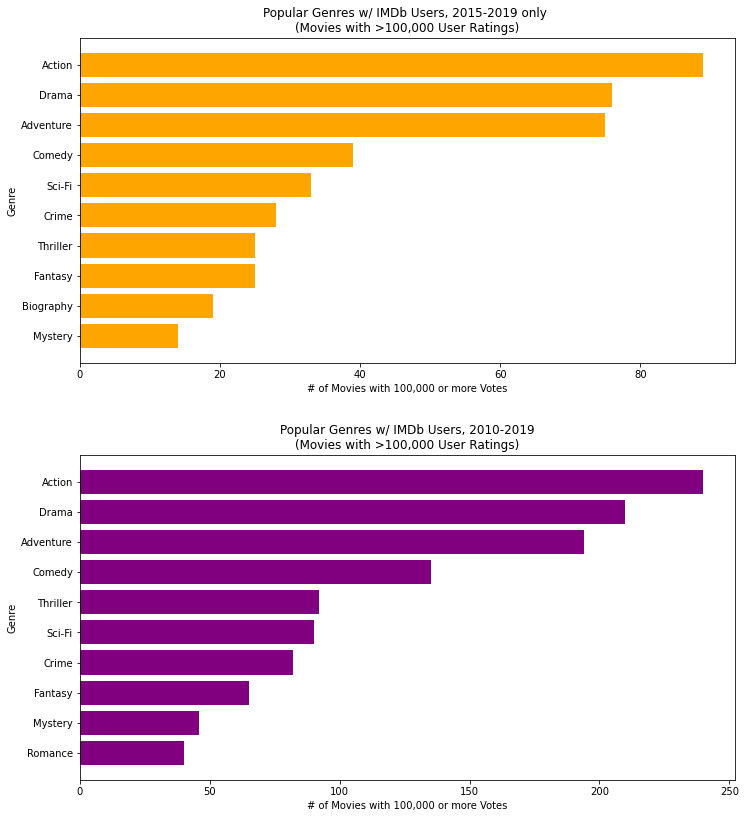

In [39]:
# Obtaining a dataframe of only movies released 2015-2019
late_decade_df = imdb_df_sample[imdb_df_sample['Release Year'] >= 2015]

# Creating another list of top ten genres
genres2 = to_1D(late_decade_df['genres']).value_counts().head(10)

# Creating a second graph
genres_fig2, ax = plt.subplots(2, figsize = (11, 12))

ax[0].invert_yaxis()
ax[0].barh(y=genres2.index,
       width=genres2,
       color='orange')
ax[0].set_title("""Popular Genres w/ IMDb Users, 2015-2019 only 
(Movies with >100,000 User Ratings)""")
ax[0].set_xlabel("# of Movies with 100,000 or more Votes")
ax[0].set_ylabel("Genre")

ax[1].invert_yaxis()
ax[1].barh(y=top_genres.index,
       width=top_genres,
       color='purple',)
ax[1].set_title("""Popular Genres w/ IMDb Users, 2010-2019
(Movies with >100,000 User Ratings)""")
ax[1].set_xlabel("# of Movies with 100,000 or more Votes")
ax[1].set_ylabel("Genre")
genres_fig2.tight_layout(pad=3.0);

These graphs are pretty comparable, both in their shapes and in their distributions of genres. We can observe an uptick in the popularity of `Sci-Fi` in the latter half of the 2010s, slightly eclipsing the popularity of `Thriller` movies (`Thriller` drops to 8<sup>th</sup> place, below `Crime` and `Fantasy`). The differences between the graphs are not profound or significant, but we can definitely comment on the increased profile of `Sci-Fi` films in the last five years' of data.

.

.

# Exploring Microsofts IPs within the Gaming Industry

Grabbed single chart from Wiki listing Microsoft Acquisitions

In [40]:
r = requests.get('https://en.wikipedia.org/wiki/List_of_mergers_and_acquisitions_by_Microsoft')
soup = BeautifulSoup(r.text)
table = soup.find('table', {'class': "wikitable sortable"})

In [41]:
len(table.find_all('tr')) 
#Checking to see if the length of the table matches the table on Wiki

271

In [42]:
Microsoft_Acquisitions_df = pd.read_html(table.prettify())[0]
Microsoft_Acquisitions_df.head()

,Date,Company,Business,Country,Value ( USD ),References
0,"July 30, 1987","Forethought, Inc.",Computer software,United States,14000000,[25]
1,"March 31, 1991",Consumers Software,Software,Canada,—,[26]
2,"June 29, 1992",Fox Software,PC database software,United States,—,[27]
3,"February 28, 1994",Softimage,Wholesale 3-D visualization software,Canada,130000000,[28]
4,"September 27, 1994",Altamira Software,Software,United States,—,[29]


In [43]:
Microsoft_Acquisitions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Date             270 non-null    object
 1   Company          270 non-null    object
 2   Business         270 non-null    object
 3   Country          270 non-null    object
 4   Value (  USD  )  256 non-null    object
 5   References       268 non-null    object
dtypes: object(6)
memory usage: 12.8+ KB


In [44]:
Microsoft_Acquisitions_df['Business'].value_counts() 
#~10% of of acquisitions by Microsoft according to this chart were in the videa gaming sector

Software                          37
Video games                       19
Internet software                  8
Internet service provider          4
Information technology             3
                                  ..
Business Intelligence software     1
Marketing automation firm          1
Networking                         1
Shopping online                    1
IP assets                          1
Name: Business, Length: 193, dtype: int64

In [45]:
Microsoft_Video_Games_df = Microsoft_Acquisitions_df[Microsoft_Acquisitions_df['Business'] == "Video games"]
#Filtered only businesses that were video games from the Microsoft acquisitions table

Remove key words that may reduce output downstream to make sure most desired data is acquired in cases where inconsistant inputs were entered in Chart.
Made `Microsoft_Owned_Studios` cantains a list of the keywords to search through data base for similarities. Added Microsoft as a development studio as well as [Bethesda](https://en.wikipedia.org/wiki/Xbox_Game_Studios) which was owned by Zenimax and is in turn owned by Microsoft.

In [46]:
Microsoft_Owned_Studios = list(Microsoft_Video_Games_df['Company']
.str.replace(" Games", "")
.str.replace(" Entertainment", "")
.str.replace(" Media", "")
.str.replace(" Studios", "")
.str.replace(" Productions", "")
.str.replace(" Blizzard", ""))+["Bethesda"]+["Microsoft"]

In [47]:
Microsoft_Owned_Studios #checked to make sure the above code worked

['FASA Interactive',
 'Access Software',
 'Bungie',
 'Digital Anvil',
 'Ensemble',
 'Rare',
 'Lionhead',
 'Twisted Pixel',
 'Press Play',
 'Mojang',
 'Ninja Theory',
 'Undead Labs',
 'Compulsion',
 'Playground',
 'inXile',
 'Obsidian',
 'Double Fine',
 'ZeniMax',
 'Activision',
 'Bethesda',
 'Microsoft']

Found and downloaded a csv file from Kaggle pertaining to video game data frame created by [RYANCOX](https://www.kaggle.com/coffeepot/videogame-sales/data)

In [48]:
video_game_df = pd.read_csv('./data/Video_Games_Sales_as_at_22_Dec_2016.csv.zip')
video_game_df.info() #looking for miss data in Sales Column and the make up the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     8137 non-null   float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       10015 non-null  object 
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           9950 non-null   object 
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


In [49]:
# Isolating Microsoft Game Studios, Activision)
# Did Ind. first to test and see individual publishers stats 
Activision_df = video_game_df.loc[(video_game_df['Publisher'] == "Activision")]
Activision_df.describe()

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Count
count,976.000000,985.000000,985.000000,985.000000,985.000000,985.000000,569.000000,569.000000,573.000000
mean,2007.315574,0.439178,0.219188,0.006812,0.076964,0.742294,69.667838,27.029877,211.874346
std,5.845428,0.899353,0.589623,0.042517,0.208207,1.628710,13.842564,20.201385,809.452931
min,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000,26.000000,3.000000,4.000000
25%,2005.000000,0.090000,0.010000,0.000000,0.010000,0.120000,60.000000,11.000000,9.000000
50%,2008.000000,0.190000,0.040000,0.000000,0.020000,0.280000,72.000000,21.000000,19.000000
75%,2011.000000,0.420000,0.170000,0.000000,0.050000,0.630000,80.000000,41.000000,61.000000
max,2016.000000,9.700000,6.210000,0.650000,2.420000,14.730000,98.000000,100.000000,9629.000000


Cleaning up `video_game_df` removing missing data, filtering to containg only microsoft owned publishers (`Microsoft_Owned_Studios`), and adding visuals.

In [50]:
video_no_NaN = video_game_df.dropna(subset= ['Publisher']) #Dropped missing values

In [51]:
('|'.join(Microsoft_Owned_Studios)) #Testing one of the filter that will go in a .str.contains()

'FASA Interactive|Access Software|Bungie|Digital Anvil|Ensemble|Rare|Lionhead|Twisted Pixel|Press Play|Mojang|Ninja Theory|Undead Labs|Compulsion|Playground|inXile|Obsidian|Double Fine|ZeniMax|Activision|Bethesda|Microsoft'

`Total_Microsoft_Df` is a df that has been filtered to contain only the publishers wanted.  Output for below cell shows the publishers that are in `Total_Microsoft_Df`

In [52]:
Total_Microsoft_Df=video_no_NaN.loc[video_no_NaN['Publisher'].str.contains('|'.join(Microsoft_Owned_Studios))]
Total_Microsoft_Df['Publisher'].value_counts()

Activision                985
Microsoft Game Studios    191
Bethesda Softworks         76
Activision Value           29
Mojang                      5
Activision Blizzard         1
inXile Entertainment        1
Name: Publisher, dtype: int64

Created data frames for `Top_20_GS`, `Top_20_NAS`, `Top_20_EUS`, and `TOP_20_JPS`.

In [53]:
Top_20_GS = Total_Microsoft_Df.groupby("Name").sum().sort_values(by= 'Global_Sales', ascending = False).head(20).reset_index()
Top_20_GS #Testing code.  
#Noticed that the games platforms were separating the sales so grouped by name so the individual games contain all of the values
#per game

,Name,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Count
0,Call of Duty: Black Ops,8040.0,17.57,9.35,0.59,3.31,30.82,410.0,214.0,4340.0
1,Call of Duty: Modern Warfare 3,8044.0,15.54,11.15,0.62,3.29,30.59,324.0,162.0,20053.0
2,Call of Duty: Black Ops II,8048.0,14.08,10.84,0.72,3.76,29.40,321.0,136.0,5041.0
3,Call of Duty: Ghosts,12078.0,14.94,8.89,0.48,3.08,27.40,369.0,101.0,5684.0
4,Call of Duty: Black Ops 3,10075.0,12.25,9.49,0.44,3.49,25.68,0.0,0.0,0.0
5,Call of Duty: Modern Warfare 2,6027.0,13.52,8.02,0.46,2.97,24.95,274.0,207.0,11201.0
6,Call of Duty: Advanced Warfare,10070.0,10.51,8.30,0.34,2.82,21.99,242.0,110.0,3905.0
7,Kinect Adventures!,2010.0,15.00,4.89,0.24,1.69,21.81,61.0,45.0,106.0
8,The Elder Scrolls V: Skyrim,10065.0,9.65,8.37,0.39,2.73,21.15,282.0,137.0,15189.0
9,Call of Duty 4: Modern Warfare,8028.0,9.99,5.75,0.42,2.04,18.19,355.0,176.0,4709.0


In [54]:
Top_20_NAS = Total_Microsoft_Df.groupby("Name").sum().sort_values(by= 'NA_Sales', ascending = False).head(20).reset_index()
Top_20_EUS = Total_Microsoft_Df.groupby("Name").sum().sort_values(by= 'EU_Sales', ascending = False).head(20).reset_index()
Top_20_JPS = Total_Microsoft_Df.groupby("Name").sum().sort_values(by= 'JP_Sales', ascending = False).head(20).reset_index()

**Global Sales Vizualizations**

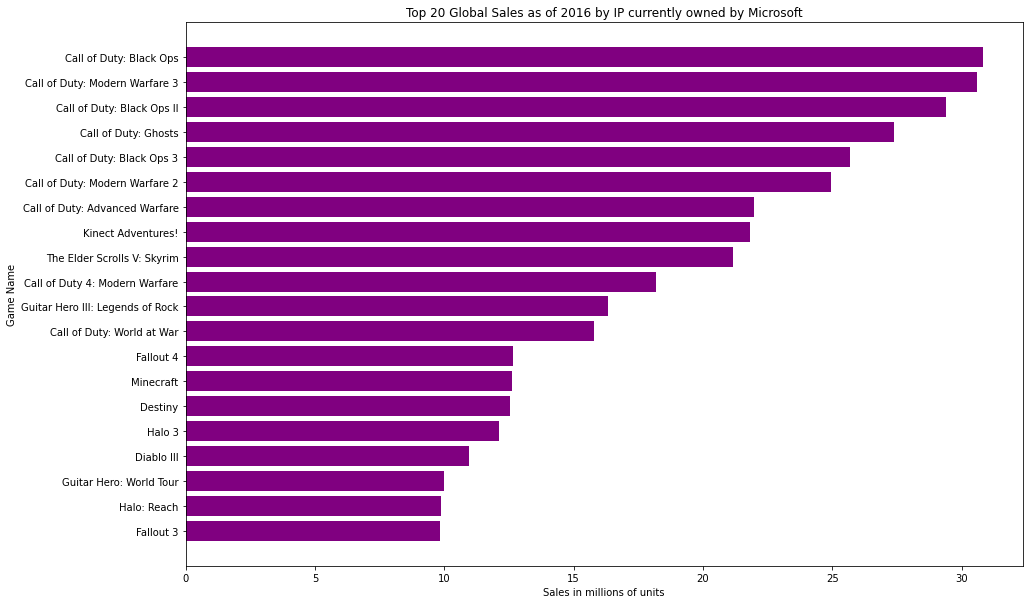

In [55]:
fig, ax = plt.subplots(figsize = (15,10))

ax.invert_yaxis()

ax.barh(y=Top_20_GS['Name'],
       width=Top_20_GS['Global_Sales'],
       color='purple')
ax.set_title("""Top 20 Global Sales as of 2016 by IP currently owned by Microsoft""")
ax.set_xlabel("Sales in millions of units")
ax.set_ylabel("Game Name");

**NA Sales Vizualizations**

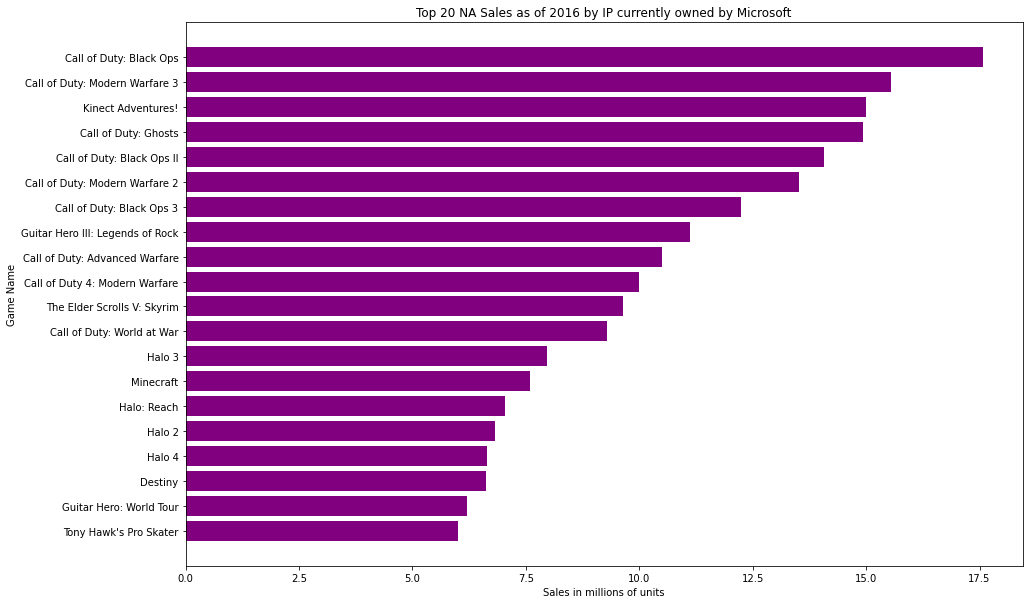

In [56]:
fig, ax = plt.subplots(figsize = (15,10))

ax.invert_yaxis()

ax.barh(y=Top_20_NAS['Name'],
       width=Top_20_NAS['NA_Sales'],
       color='purple')
ax.set_title("""Top 20 NA Sales as of 2016 by IP currently owned by Microsoft""")
ax.set_xlabel("Sales in millions of units")
ax.set_ylabel("Game Name");

**EU Sales Vizualizations**

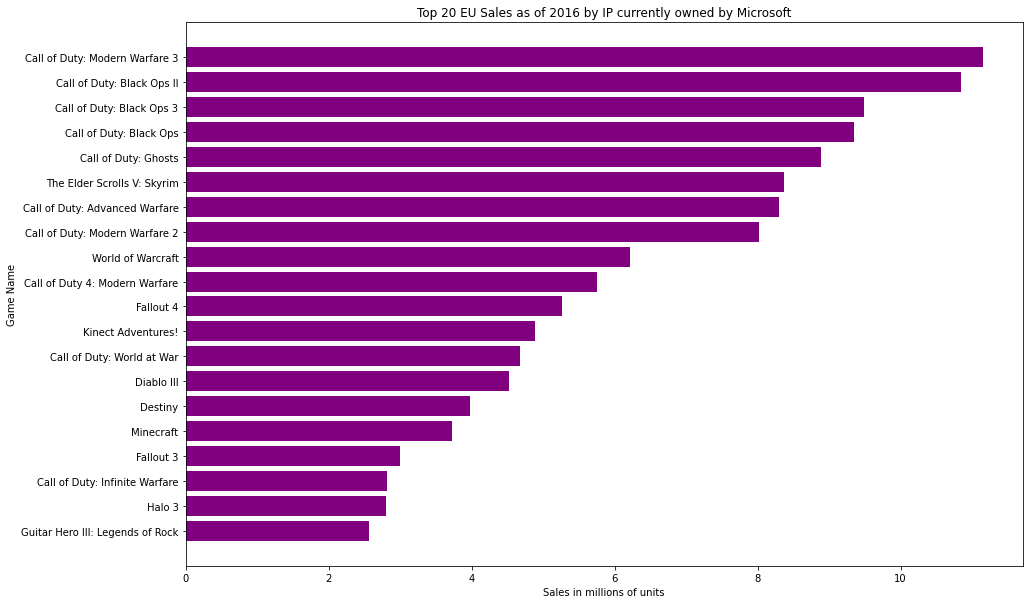

In [57]:
fig, ax = plt.subplots(figsize = (15,10))

ax.invert_yaxis()

ax.barh(y=Top_20_EUS['Name'],
       width=Top_20_EUS['EU_Sales'],
       color='purple')
ax.set_title("""Top 20 EU Sales as of 2016 by IP currently owned by Microsoft""")
ax.set_xlabel("Sales in millions of units")
ax.set_ylabel("Game Name");

**JP Sales Vizualizations**

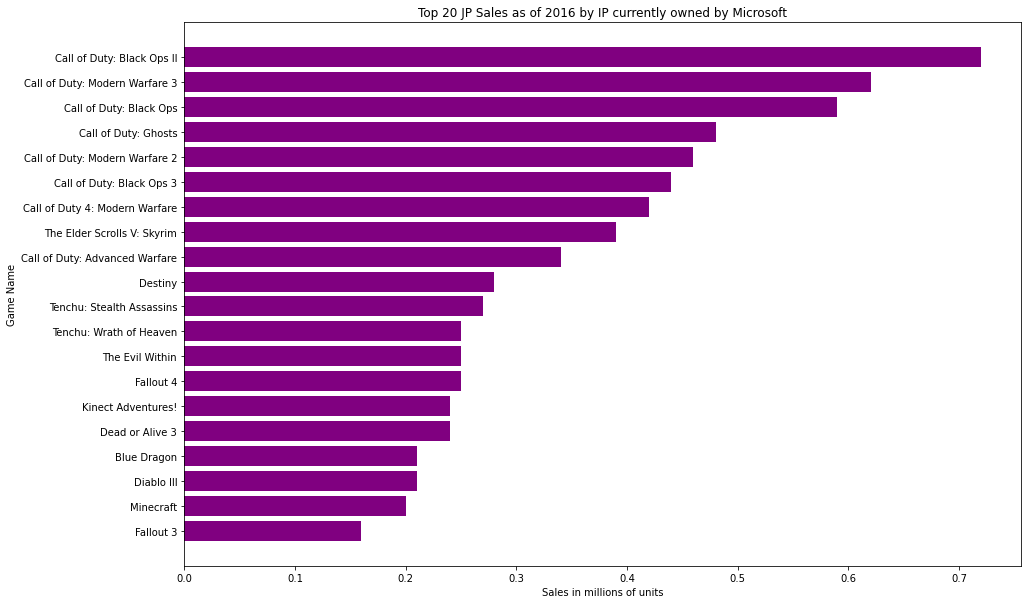

In [58]:
fig, ax = plt.subplots(figsize = (15,10))

ax.invert_yaxis()

ax.barh(y=Top_20_JPS['Name'],
       width=Top_20_JPS['JP_Sales'],
       color='purple')
ax.set_title("""Top 20 JP Sales as of 2016 by IP currently owned by Microsoft""")
ax.set_xlabel("Sales in millions of units")
ax.set_ylabel("Game Name");